In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Reshape, UpSampling2D, Conv2D, Activation, LeakyReLU, Dropout, Flatten

# DCGAN(Deep Convolutional GAN) : 컨볼루션 신경망(CNN)을 GAN에 적용한 알고리즘
  # - 옵티마이저를 사용하는 최적화 과정이나 컴파일 과정이 없음
  # - 일부 매개변수를 삭제하는 풀링(pooling) 과정이 없는 대신 패딩(padding) 과정이 필요함 : 입출력 크기를 똑같이 맞추기 위해서
    # => padding = 'same' 설정 넣으면 입출력 크기가 다를 경우 자동으로 크기 확장해 주고, 확장된 공간에 0을 채워 넣어줌
  # - 작은 크기의 이미지를 점점 늘려 가면서 컨볼루션 층을 지나가게 하는것이 특징(7*7 > 14*14 > 28*28 )

# 배치 정규화(Batch Normalization) : 입력 데이터의 평균이 0, 분산이 1이 되도록 재배치하는 것 => BatchNormalization() 함수 제공
# 생성자의 활성함수 : ReLU() 사용, 판별자로 넘겨주기 직전 : tanh() 함수 사용

# 생성자 모델 만들기
generator = Sequential()

# 128 > 임의로 정한 노드의 수, input_dim=100 > 100차원 크기의 랜덤 벡터를 준비해 집어넣으라는 의미.적절한 숫자를 임의로 넣어주면 됨
# 7*7 > 이미지의 최초크기, UpSampling2D() 함수를 사용하면 가로세로 크기 두배씩 증가하기 때문에 7*7

# 활성화 함수 LeakyReLU(리키렐루)
  # - ReLU() 함수에서 x 값이 음수이면 무조건 0이 되어 뉴런들이 일찍 소실되는 단점을 보완하기 위해, 0 이하에서도 작은 값을 갖게 만드는 함수
  # - LeakyReLU(0.2) : 0보다 작을 경우 0.2를 곱하라는 의미
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))

# 데이터의 배치를 정규 분포로 만드는 배치 정규화가 진행됨
generator.add(BatchNormalization())

# 컨볼루션 레이어가 받아들일 수 있는 형태로 바꾸어 줌. Conv2D() 함수의 input_shape=(행, 열, 색상(3) 또는 흑백(1)??) 부분에 들어갈 형태로 바꾸어주는 것
generator.add(Reshape((7, 7, 128)))

# UpSampling + Conv2D => Conv2DTranspose() 함수 하나로 사용 가능
generator.add(UpSampling2D())
# 커널 사이즈 : 5로 해서 5*5 커널 사용. padding='same' 모자라는 부분은 자동으로 0이 채워짐
generator.add(Conv2D(64, kernel_size=5, padding='same'))

generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))

# UpSampling + Conv2D => Conv2DTranspose() 함수 하나로 사용 가능
generator.add(UpSampling2D())
# 끝 에서 한번 더 컨볼루션 과정을 거친 후 판별자로 값을 넘길 준비 마침. 활성화 함수는 tanh()
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [3]:
# 판별자(discriminator)
  # - 컨볼루션 신경망 구조 그대로 사용하여 진짜와 가짜를 구별함
  # - 진짜 : 1, 가짜 : 0
  # - 가짜인지 진짜인지를 판별만 해 줄 뿐, 자기 자신이 학습을 해서는 안됨
  # - 판별자가 얻은 가중치는 학습하지말고 생성자로 넘겨주어 생성자가 업데이트 된 이미지를 만들도록 해야함 => 가중치 저장하는 학습 기능을 꺼주어야함

discriminator = Sequential()

# node : 64, kernel : 5*5
# strides : 커널 윈도를 몇 칸씩 이동시킬지 정하는 옵션. 2일때는 커널 윈도를 두 칸씩 움직이라는 뜻
  # - 여러칸 움직이는 이유 : 가로세로 크기가 더 줄어들어 새로운 특징을 뽑아 주는 효과가 생기기 때문 (드롭아웃, 풀링처럼 새로운 필터를 적용한 효과가 생기는 것)
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

# Flatten() : 가로x세로의 2차원으로 진행된 과정을 1차원으로 바꾸어 줌
discriminator.add(Flatten())

# 활성화 함수 sigmoid() : 판별의 결과가 진짜(1) 혹은 가짜(0) 둘 중에 하나가 되어야 하기 때문에
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# 판별이 끝나고 나면 판별자 자신이 학습되지 않게끔 학습 기능을 꺼주는 것
discriminator.trainable = False

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# 적대적 신경망 실행하기 : 생성자와 판별자를 연결시키고 학습을 진행
  # - 생성자는 D(G(input))이 참(1)이라고 주장하지만, 판별자는 실제 데이터인 x로 만든 D(x)만이 참이라고 여김
  # - 학습이 진행될수록 생성자가 만든 G(input)이 실제와 너무나 가까워져서 이것으로 만든 D(G(input))과 실제 데이터 D(x)를 
  #   판별자가 더는 구별하지 못하게 되어
  # - 정확도가 0.5에 가까워질 때, 비로소 생성자는 자신의 역할을 다하게 되어 학습은 종료됨

# 랜덤한 100개의 벡터를 케라스의 Input() 함수에 집어넣어 생성자에 입력할 ginput을 만드는 것
ginput = Input(shape=(100,))


# 생성자 모델 generator()에 ginput을 입력함 > 출력되는 28*28 이미지가 그대로 판별자 모델 discriminator()의 입력값으로 들어감 > 참과 거짓을 판별한 결과 = dis_output
dis_output = discriminator(generator(ginput))

# Model 함수를 이용해 ginput 값과 dis_output 값을 넣어 gan 이라는 새로운 모델을 만듦
gan = Model(ginput, dis_output)

# 참과 거짓을 구분하는 이진 로스 함수(binary_crossentropy)와 최적화 함수(adam) 사용해 컴파일 진행
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7733965071027332926
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9901047808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3062040580451579088
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [6]:
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [7]:
from tensorflow.keras.datasets import mnist

with tf.device('/GPU:0'):
    # 실행할 함수를 선언
    def gan_train(epoch, batch_size, saving_interval): # 세 가지 변수 지정

        # MNIST 데이터 불러오기
        # MNIST 데이터를 불러와 이용하는데 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 호출
        (X_train, _), (_, _) = mnist.load_data()

        # 가로 28픽셀, 세로 28픽셀이고 흑백이므로 1을 설정
        X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

        # 0~255 사이 픽셀 값에서 127.5를 뺀 후 127.5로 나누면 -1~1 사이 값으로 바뀜
        X_train = (X_train - 127.5) / 127.5

        #############################################################################
        # batch_size만큼 MNIST 손글씨 이미지를 랜덤하게 불러와 판별자에 집어넣는 과정 : 실제 이미지
        # 실제 이미지를 입력했으므로 '모두 참(1)'이라는 레이블을 붙임
        # batch_size : 한 번에 몇 개의 실제 이미지와 몇 개의 가상 이미지를 판별자에 넣을지 결정하는 변수
        true = np.ones((batch_size, 1))

        # '모두 거짓(0)'이라는 레이블 값을 batch_size 길이만큼 만들기
        fake = np.zeros((batch_size, 1))


        for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분

            # 넘파이 라이브러리 random() 함수 사용해서 실제 이미지를 랜덤하게 선택해 불러옴
            # np.random.randint(a, b, c) : a부터 b까지 숫자 중 하나를 랜덤하게 선택해 가져오는 과정을 c번 반복하라는 의미
            #                              => 0부터 X_train 개수 사이의 숫자를 랜덤하게 선택해 batch_size 만큼 반복해서 가져오게 함
            idx = np.random.randint(0, X_train.shape[0], batch_size)

            # idx에서 선택된 이미지를 불러옴
            imgs = X_train[idx]

            # 판별자 모델에 train_on_batch() 함수 써서 판별 시작
            # train_on_batch(x, y) : 입력 값(x)과 레이블(y)을 받아서 딱 한 번 학습을 실시해 모델을 업데이트함
            d_loss_real = discriminator.train_on_batch(imgs, true)

            #############################################################################
            # 생성자에서 만든 가상의 이미지를 판별자에 넣기
            # 학습이 반복될수록 가짜라는 레이블을 붙인 이미지들에 대한 예측 결과가 거짓으로 나올 것

            # 생성자에 집어넣을 가상 이미지 만들기 : 정수가 아니기 때문에 np.random.normal() 사용
            # np.random.normal(a, b, c) : a부터 b까지의 실수 중 c개를 랜덤으로 뽑으라는 의미
            # c 자리의 (batch_size, 100)은 batch_size만큼 100열을 뽑으라는 의미
            noise = np.random.normal(0, 1, (batch_size, 100))

            # 위에서 만들어진 가상이미지가 생성자에 들어가고 결과값이 gen_imgs로 저장됨
            gen_imgs = generator.predict(noise)

            # 판별자 모델에 gen_imgs (생성자를 통해 )
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

            # 판별자와 생성자의 오차를 계산함
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = gan.train_on_batch(noise, true)

            print('epoch : {0}, d_loss : {1:.4f}, g_loss : {2:.4f}' .format(i, d_loss, g_loss))

            ##########################################################################
            # 중간 과정을 이미지로 저장
            # 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미

            if i % saving_interval == 0:

                #r, c = 5, 5
                noise = np.random.normal(0, 1, (25, 100))
                gen_imgs = generator.predict(noise)

                # Rescale images 0 - 1
                gen_imgs = 0.5 * gen_imgs + 0.5

                fig, axs = plt.subplots(5,5)
                count = 0
                for j in range(5):
                    for k in range(5):
                        axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
                        axs[j, k].axis('off')
                        count += 1
            # plt.savefig('gan_images/gan_mnist_{0}.png' .format(i))




1/1 [==============================] - 0s 322ms/step
epoch : 0, d_loss : 0.6498, g_loss : 0.7467
1/1 [==============================] - 0s 8ms/step
epoch : 1, d_loss : 0.3595, g_loss : 0.3684
1/1 [==============================] - 0s 9ms/step
epoch : 2, d_loss : 0.4097, g_loss : 0.0683
1/1 [==============================] - 0s 8ms/step
epoch : 3, d_loss : 0.7179, g_loss : 0.0327
1/1 [==============================] - 0s 8ms/step
epoch : 4, d_loss : 0.8374, g_loss : 0.0680
1/1 [==============================] - 0s 8ms/step
epoch : 5, d_loss : 0.6367, g_loss : 0.3225
1/1 [==============================] - 0s 8ms/step
epoch : 6, d_loss : 0.4524, g_loss : 1.0460
1/1 [==============================] - 0s 8ms/step
epoch : 7, d_loss : 0.5519, g_loss : 1.1616
1/1 [==============================] - 0s 9ms/step
epoch : 8, d_loss : 0.5395, g_loss : 0.9531
1/1 [==============================] - 0s 8ms/step
epoch : 9, d_loss : 0.4542, g_loss : 0.8053
1/1 [==============================] - 0s 8ms/st

1/1 [==============================] - 0s 12ms/step
epoch : 85, d_loss : 0.7935, g_loss : 2.3294
1/1 [==============================] - 0s 10ms/step
epoch : 86, d_loss : 0.5343, g_loss : 3.2430
1/1 [==============================] - 0s 9ms/step
epoch : 87, d_loss : 0.5083, g_loss : 3.5144
1/1 [==============================] - 0s 9ms/step
epoch : 88, d_loss : 0.5366, g_loss : 3.2633
1/1 [==============================] - 0s 8ms/step
epoch : 89, d_loss : 0.5019, g_loss : 3.1222
1/1 [==============================] - 0s 11ms/step
epoch : 90, d_loss : 0.4498, g_loss : 2.6969
1/1 [==============================] - 0s 8ms/step
epoch : 91, d_loss : 0.3123, g_loss : 2.5637
1/1 [==============================] - 0s 8ms/step
epoch : 92, d_loss : 0.4590, g_loss : 2.7324
1/1 [==============================] - 0s 8ms/step
epoch : 93, d_loss : 0.5632, g_loss : 2.4040
1/1 [==============================] - 0s 8ms/step
epoch : 94, d_loss : 0.7858, g_loss : 1.8918
1/1 [==============================] 

1/1 [==============================] - 0s 9ms/step
epoch : 169, d_loss : 0.3619, g_loss : 2.2641
1/1 [==============================] - 0s 9ms/step
epoch : 170, d_loss : 0.3324, g_loss : 1.9864
1/1 [==============================] - 0s 9ms/step
epoch : 171, d_loss : 0.2763, g_loss : 2.7900
1/1 [==============================] - 0s 9ms/step
epoch : 172, d_loss : 0.3544, g_loss : 2.7037
1/1 [==============================] - 0s 8ms/step
epoch : 173, d_loss : 0.4583, g_loss : 2.8026
1/1 [==============================] - 0s 9ms/step
epoch : 174, d_loss : 0.6945, g_loss : 2.4085
1/1 [==============================] - 0s 9ms/step
epoch : 175, d_loss : 0.7673, g_loss : 2.1401
1/1 [==============================] - 0s 9ms/step
epoch : 176, d_loss : 0.6992, g_loss : 1.7235
1/1 [==============================] - 0s 8ms/step
epoch : 177, d_loss : 0.7238, g_loss : 1.6079
1/1 [==============================] - 0s 9ms/step
epoch : 178, d_loss : 0.7718, g_loss : 1.7333
1/1 [=========================

1/1 [==============================] - 0s 8ms/step
epoch : 253, d_loss : 0.6078, g_loss : 1.0089
1/1 [==============================] - 0s 8ms/step
epoch : 254, d_loss : 0.6713, g_loss : 1.1254
1/1 [==============================] - 0s 9ms/step
epoch : 255, d_loss : 0.5223, g_loss : 1.2979
1/1 [==============================] - 0s 8ms/step
epoch : 256, d_loss : 0.4928, g_loss : 1.3090
1/1 [==============================] - 0s 8ms/step
epoch : 257, d_loss : 0.5439, g_loss : 1.3735
1/1 [==============================] - 0s 9ms/step
epoch : 258, d_loss : 0.5216, g_loss : 1.4730
1/1 [==============================] - 0s 9ms/step
epoch : 259, d_loss : 0.4539, g_loss : 1.5453
1/1 [==============================] - 0s 8ms/step
epoch : 260, d_loss : 0.4261, g_loss : 1.6795
1/1 [==============================] - 0s 9ms/step
epoch : 261, d_loss : 0.5007, g_loss : 1.3939
1/1 [==============================] - 0s 8ms/step
epoch : 262, d_loss : 0.3700, g_loss : 1.6009
1/1 [=========================

1/1 [==============================] - 0s 9ms/step
epoch : 337, d_loss : 0.4996, g_loss : 1.7263
1/1 [==============================] - 0s 10ms/step
epoch : 338, d_loss : 0.3965, g_loss : 1.9232
1/1 [==============================] - 0s 8ms/step
epoch : 339, d_loss : 0.5026, g_loss : 1.8672
1/1 [==============================] - 0s 8ms/step
epoch : 340, d_loss : 0.4394, g_loss : 1.8793
1/1 [==============================] - 0s 8ms/step
epoch : 341, d_loss : 0.4741, g_loss : 1.7574
1/1 [==============================] - 0s 9ms/step
epoch : 342, d_loss : 0.5341, g_loss : 2.0502
1/1 [==============================] - 0s 9ms/step
epoch : 343, d_loss : 0.6011, g_loss : 2.0190
1/1 [==============================] - 0s 8ms/step
epoch : 344, d_loss : 0.5843, g_loss : 2.0556
1/1 [==============================] - 0s 9ms/step
epoch : 345, d_loss : 0.6012, g_loss : 1.5263
1/1 [==============================] - 0s 12ms/step
epoch : 346, d_loss : 0.5405, g_loss : 1.8496
1/1 [=======================

1/1 [==============================] - 0s 10ms/step
epoch : 421, d_loss : 0.3798, g_loss : 2.7766
1/1 [==============================] - 0s 9ms/step
epoch : 422, d_loss : 0.3319, g_loss : 2.5827
1/1 [==============================] - 0s 9ms/step
epoch : 423, d_loss : 0.3051, g_loss : 2.5118
1/1 [==============================] - 0s 9ms/step
epoch : 424, d_loss : 0.4652, g_loss : 1.7533
1/1 [==============================] - 0s 9ms/step
epoch : 425, d_loss : 0.3502, g_loss : 1.5730
1/1 [==============================] - 0s 9ms/step
epoch : 426, d_loss : 0.4160, g_loss : 1.8043
1/1 [==============================] - 0s 8ms/step
epoch : 427, d_loss : 0.3620, g_loss : 1.8882
1/1 [==============================] - 0s 9ms/step
epoch : 428, d_loss : 0.2660, g_loss : 2.5634
1/1 [==============================] - 0s 9ms/step
epoch : 429, d_loss : 0.2848, g_loss : 2.7544
1/1 [==============================] - 0s 9ms/step
epoch : 430, d_loss : 0.4194, g_loss : 2.9154
1/1 [========================

1/1 [==============================] - 0s 9ms/step
epoch : 505, d_loss : 0.1907, g_loss : 3.0846
1/1 [==============================] - 0s 8ms/step
epoch : 506, d_loss : 0.2247, g_loss : 3.5047
1/1 [==============================] - 0s 8ms/step
epoch : 507, d_loss : 0.2069, g_loss : 2.9424
1/1 [==============================] - 0s 9ms/step
epoch : 508, d_loss : 0.1917, g_loss : 2.1619
1/1 [==============================] - 0s 9ms/step
epoch : 509, d_loss : 0.1925, g_loss : 2.2950
1/1 [==============================] - 0s 9ms/step
epoch : 510, d_loss : 0.2069, g_loss : 3.0529
1/1 [==============================] - 0s 9ms/step
epoch : 511, d_loss : 0.2160, g_loss : 3.4097
1/1 [==============================] - 0s 8ms/step
epoch : 512, d_loss : 0.2475, g_loss : 3.3515
1/1 [==============================] - 0s 11ms/step
epoch : 513, d_loss : 0.1714, g_loss : 3.1696
1/1 [==============================] - 0s 10ms/step
epoch : 514, d_loss : 0.2517, g_loss : 2.2940
1/1 [=======================

1/1 [==============================] - 0s 9ms/step
epoch : 589, d_loss : 0.1920, g_loss : 3.4876
1/1 [==============================] - 0s 9ms/step
epoch : 590, d_loss : 0.2892, g_loss : 2.4569
1/1 [==============================] - 0s 9ms/step
epoch : 591, d_loss : 0.2443, g_loss : 2.1504
1/1 [==============================] - 0s 8ms/step
epoch : 592, d_loss : 0.1689, g_loss : 2.3631
1/1 [==============================] - 0s 8ms/step
epoch : 593, d_loss : 0.2669, g_loss : 2.3817
1/1 [==============================] - 0s 9ms/step
epoch : 594, d_loss : 0.3016, g_loss : 2.4695
1/1 [==============================] - 0s 8ms/step
epoch : 595, d_loss : 0.1464, g_loss : 3.0893
1/1 [==============================] - 0s 8ms/step
epoch : 596, d_loss : 0.2495, g_loss : 2.8036
1/1 [==============================] - 0s 9ms/step
epoch : 597, d_loss : 0.1815, g_loss : 2.2135
1/1 [==============================] - 0s 9ms/step
epoch : 598, d_loss : 0.2856, g_loss : 2.2677
1/1 [=========================

1/1 [==============================] - 0s 8ms/step
epoch : 673, d_loss : 0.5792, g_loss : 2.9020
1/1 [==============================] - 0s 9ms/step
epoch : 674, d_loss : 0.7751, g_loss : 2.4960
1/1 [==============================] - 0s 8ms/step
epoch : 675, d_loss : 0.5846, g_loss : 2.1109
1/1 [==============================] - 0s 10ms/step
epoch : 676, d_loss : 0.6843, g_loss : 2.0552
1/1 [==============================] - 0s 9ms/step
epoch : 677, d_loss : 0.7785, g_loss : 1.2982
1/1 [==============================] - 0s 9ms/step
epoch : 678, d_loss : 0.7070, g_loss : 1.4779
1/1 [==============================] - 0s 9ms/step
epoch : 679, d_loss : 1.2050, g_loss : 1.3979
1/1 [==============================] - 0s 9ms/step
epoch : 680, d_loss : 0.9372, g_loss : 1.2419
1/1 [==============================] - 0s 9ms/step
epoch : 681, d_loss : 0.8863, g_loss : 1.7246
1/1 [==============================] - 0s 9ms/step
epoch : 682, d_loss : 0.5475, g_loss : 1.8846
1/1 [========================

1/1 [==============================] - 0s 12ms/step
epoch : 757, d_loss : 0.1996, g_loss : 2.9680
1/1 [==============================] - 0s 9ms/step
epoch : 758, d_loss : 0.2290, g_loss : 2.7682
1/1 [==============================] - 0s 9ms/step
epoch : 759, d_loss : 0.2481, g_loss : 3.2930
1/1 [==============================] - 0s 9ms/step
epoch : 760, d_loss : 0.2992, g_loss : 2.4491
1/1 [==============================] - 0s 14ms/step
epoch : 761, d_loss : 0.2300, g_loss : 2.0410
1/1 [==============================] - 0s 10ms/step
epoch : 762, d_loss : 0.3875, g_loss : 1.6199
1/1 [==============================] - 0s 10ms/step
epoch : 763, d_loss : 0.4065, g_loss : 1.5750
1/1 [==============================] - 0s 8ms/step
epoch : 764, d_loss : 0.3984, g_loss : 1.7251
1/1 [==============================] - 0s 10ms/step
epoch : 765, d_loss : 0.2456, g_loss : 2.6161
1/1 [==============================] - 0s 8ms/step
epoch : 766, d_loss : 0.3213, g_loss : 2.5916
1/1 [====================

1/1 [==============================] - 0s 8ms/step
epoch : 841, d_loss : 0.7449, g_loss : 0.7740
1/1 [==============================] - 0s 8ms/step
epoch : 842, d_loss : 0.5321, g_loss : 0.9901
1/1 [==============================] - 0s 8ms/step
epoch : 843, d_loss : 0.6527, g_loss : 1.0185
1/1 [==============================] - 0s 9ms/step
epoch : 844, d_loss : 0.8094, g_loss : 0.8906
1/1 [==============================] - 0s 9ms/step
epoch : 845, d_loss : 0.6970, g_loss : 1.0327
1/1 [==============================] - 0s 8ms/step
epoch : 846, d_loss : 0.5930, g_loss : 0.8751
1/1 [==============================] - 0s 8ms/step
epoch : 847, d_loss : 0.8537, g_loss : 0.6909
1/1 [==============================] - 0s 8ms/step
epoch : 848, d_loss : 0.6763, g_loss : 0.8992
1/1 [==============================] - 0s 9ms/step
epoch : 849, d_loss : 0.4821, g_loss : 1.1664
1/1 [==============================] - 0s 8ms/step
epoch : 850, d_loss : 0.5421, g_loss : 1.3106
1/1 [=========================

1/1 [==============================] - 0s 8ms/step
epoch : 925, d_loss : 0.7234, g_loss : 1.4173
1/1 [==============================] - 0s 8ms/step
epoch : 926, d_loss : 0.6910, g_loss : 1.2011
1/1 [==============================] - 0s 9ms/step
epoch : 927, d_loss : 0.5883, g_loss : 1.2932
1/1 [==============================] - 0s 9ms/step
epoch : 928, d_loss : 0.5400, g_loss : 1.4093
1/1 [==============================] - 0s 9ms/step
epoch : 929, d_loss : 0.5144, g_loss : 1.3839
1/1 [==============================] - 0s 8ms/step
epoch : 930, d_loss : 0.6141, g_loss : 1.6684
1/1 [==============================] - 0s 9ms/step
epoch : 931, d_loss : 0.4086, g_loss : 1.9686
1/1 [==============================] - 0s 9ms/step
epoch : 932, d_loss : 0.4160, g_loss : 1.9577
1/1 [==============================] - 0s 9ms/step
epoch : 933, d_loss : 0.4037, g_loss : 1.8868
1/1 [==============================] - 0s 9ms/step
epoch : 934, d_loss : 0.5595, g_loss : 1.5270
1/1 [=========================

1/1 [==============================] - 0s 9ms/step
epoch : 1009, d_loss : 0.4414, g_loss : 1.6942
1/1 [==============================] - 0s 8ms/step
epoch : 1010, d_loss : 0.6227, g_loss : 1.2307
1/1 [==============================] - 0s 9ms/step
epoch : 1011, d_loss : 0.4582, g_loss : 1.6112
1/1 [==============================] - 0s 9ms/step
epoch : 1012, d_loss : 0.4390, g_loss : 2.0297
1/1 [==============================] - 0s 11ms/step
epoch : 1013, d_loss : 0.4805, g_loss : 2.0653
1/1 [==============================] - 0s 8ms/step
epoch : 1014, d_loss : 0.4983, g_loss : 1.4574
1/1 [==============================] - 0s 8ms/step
epoch : 1015, d_loss : 0.3795, g_loss : 1.4370
1/1 [==============================] - 0s 9ms/step
epoch : 1016, d_loss : 0.4631, g_loss : 1.6128
1/1 [==============================] - 0s 9ms/step
epoch : 1017, d_loss : 0.5146, g_loss : 1.3247
1/1 [==============================] - 0s 8ms/step
epoch : 1018, d_loss : 0.4006, g_loss : 1.9312
1/1 [==============

1/1 [==============================] - 0s 9ms/step
epoch : 1092, d_loss : 0.4853, g_loss : 1.3470
1/1 [==============================] - 0s 8ms/step
epoch : 1093, d_loss : 0.6350, g_loss : 1.3912
1/1 [==============================] - 0s 9ms/step
epoch : 1094, d_loss : 0.4723, g_loss : 1.2958
1/1 [==============================] - 0s 8ms/step
epoch : 1095, d_loss : 0.4788, g_loss : 1.6447
1/1 [==============================] - 0s 9ms/step
epoch : 1096, d_loss : 0.6529, g_loss : 1.4869
1/1 [==============================] - 0s 9ms/step
epoch : 1097, d_loss : 0.4175, g_loss : 1.9834
1/1 [==============================] - 0s 9ms/step
epoch : 1098, d_loss : 0.4419, g_loss : 1.3684
1/1 [==============================] - 0s 8ms/step
epoch : 1099, d_loss : 0.5473, g_loss : 1.5654
1/1 [==============================] - 0s 8ms/step
epoch : 1100, d_loss : 0.4938, g_loss : 1.1914
1/1 [==============================] - 0s 9ms/step
epoch : 1101, d_loss : 0.4936, g_loss : 1.7246
1/1 [===============

1/1 [==============================] - 0s 9ms/step
epoch : 1176, d_loss : 0.6888, g_loss : 1.5234
1/1 [==============================] - 0s 8ms/step
epoch : 1177, d_loss : 0.6876, g_loss : 1.3105
1/1 [==============================] - 0s 8ms/step
epoch : 1178, d_loss : 0.5767, g_loss : 1.4732
1/1 [==============================] - 0s 8ms/step
epoch : 1179, d_loss : 0.4951, g_loss : 1.4708
1/1 [==============================] - 0s 9ms/step
epoch : 1180, d_loss : 0.5853, g_loss : 1.6117
1/1 [==============================] - 0s 9ms/step
epoch : 1181, d_loss : 0.4553, g_loss : 1.4999
1/1 [==============================] - 0s 9ms/step
epoch : 1182, d_loss : 0.4892, g_loss : 1.5376
1/1 [==============================] - 0s 8ms/step
epoch : 1183, d_loss : 0.5420, g_loss : 1.4342
1/1 [==============================] - 0s 8ms/step
epoch : 1184, d_loss : 0.4604, g_loss : 1.2025
1/1 [==============================] - 0s 9ms/step
epoch : 1185, d_loss : 0.5856, g_loss : 1.4396
1/1 [===============

1/1 [==============================] - 0s 9ms/step
epoch : 1259, d_loss : 0.4602, g_loss : 1.7013
1/1 [==============================] - 0s 9ms/step
epoch : 1260, d_loss : 0.4083, g_loss : 1.7797
1/1 [==============================] - 0s 12ms/step
epoch : 1261, d_loss : 0.4027, g_loss : 1.7096
1/1 [==============================] - 0s 9ms/step
epoch : 1262, d_loss : 0.5530, g_loss : 1.7901
1/1 [==============================] - 0s 9ms/step
epoch : 1263, d_loss : 0.4941, g_loss : 1.8190
1/1 [==============================] - 0s 9ms/step
epoch : 1264, d_loss : 0.5410, g_loss : 1.7259
1/1 [==============================] - 0s 9ms/step
epoch : 1265, d_loss : 0.5334, g_loss : 1.5306
1/1 [==============================] - 0s 10ms/step
epoch : 1266, d_loss : 0.5225, g_loss : 1.5155
1/1 [==============================] - 0s 8ms/step
epoch : 1267, d_loss : 0.5113, g_loss : 1.5871
1/1 [==============================] - 0s 8ms/step
epoch : 1268, d_loss : 0.5134, g_loss : 1.2897
1/1 [=============

epoch : 1342, d_loss : 0.4926, g_loss : 1.5423
1/1 [==============================] - 0s 11ms/step
epoch : 1343, d_loss : 0.7025, g_loss : 1.4315
1/1 [==============================] - 0s 10ms/step
epoch : 1344, d_loss : 0.5118, g_loss : 1.5875
1/1 [==============================] - 0s 9ms/step
epoch : 1345, d_loss : 0.4478, g_loss : 1.8911
1/1 [==============================] - 0s 11ms/step
epoch : 1346, d_loss : 0.5016, g_loss : 2.1255
1/1 [==============================] - 0s 10ms/step
epoch : 1347, d_loss : 0.5260, g_loss : 1.8873
1/1 [==============================] - 0s 9ms/step
epoch : 1348, d_loss : 0.5628, g_loss : 2.0464
1/1 [==============================] - 0s 9ms/step
epoch : 1349, d_loss : 0.4398, g_loss : 1.6792
1/1 [==============================] - 0s 9ms/step
epoch : 1350, d_loss : 0.3823, g_loss : 1.5123
1/1 [==============================] - 0s 8ms/step
epoch : 1351, d_loss : 0.4864, g_loss : 1.7689
1/1 [==============================] - 0s 9ms/step
epoch : 1352, d_

1/1 [==============================] - 0s 8ms/step
epoch : 1425, d_loss : 0.4016, g_loss : 1.7942
1/1 [==============================] - 0s 8ms/step
epoch : 1426, d_loss : 0.3606, g_loss : 1.7377
1/1 [==============================] - 0s 9ms/step
epoch : 1427, d_loss : 0.4683, g_loss : 1.8605
1/1 [==============================] - 0s 9ms/step
epoch : 1428, d_loss : 0.5025, g_loss : 1.5385
1/1 [==============================] - 0s 8ms/step
epoch : 1429, d_loss : 0.4175, g_loss : 2.0595
1/1 [==============================] - 0s 9ms/step
epoch : 1430, d_loss : 0.4785, g_loss : 2.0892
1/1 [==============================] - 0s 9ms/step
epoch : 1431, d_loss : 0.4698, g_loss : 1.9583
1/1 [==============================] - 0s 8ms/step
epoch : 1432, d_loss : 0.4130, g_loss : 2.1463
1/1 [==============================] - 0s 9ms/step
epoch : 1433, d_loss : 0.4275, g_loss : 2.1627
1/1 [==============================] - 0s 8ms/step
epoch : 1434, d_loss : 0.3975, g_loss : 2.0896
1/1 [===============

epoch : 1508, d_loss : 0.4339, g_loss : 2.2425
1/1 [==============================] - 0s 9ms/step
epoch : 1509, d_loss : 0.3279, g_loss : 1.9518
1/1 [==============================] - 0s 8ms/step
epoch : 1510, d_loss : 0.4239, g_loss : 2.3484
1/1 [==============================] - 0s 8ms/step
epoch : 1511, d_loss : 0.4189, g_loss : 2.2464
1/1 [==============================] - 0s 8ms/step
epoch : 1512, d_loss : 0.3801, g_loss : 2.0131
1/1 [==============================] - 0s 10ms/step
epoch : 1513, d_loss : 0.3733, g_loss : 2.3885
1/1 [==============================] - 0s 9ms/step
epoch : 1514, d_loss : 0.3372, g_loss : 2.5222
1/1 [==============================] - 0s 9ms/step
epoch : 1515, d_loss : 0.4177, g_loss : 2.2803
1/1 [==============================] - 0s 9ms/step
epoch : 1516, d_loss : 0.4839, g_loss : 2.1489
1/1 [==============================] - 0s 8ms/step
epoch : 1517, d_loss : 0.4204, g_loss : 1.8803
1/1 [==============================] - 0s 9ms/step
epoch : 1518, d_los

1/1 [==============================] - 0s 9ms/step
epoch : 1592, d_loss : 0.3394, g_loss : 1.5851
1/1 [==============================] - 0s 9ms/step
epoch : 1593, d_loss : 0.4989, g_loss : 1.7716
1/1 [==============================] - 0s 9ms/step
epoch : 1594, d_loss : 0.5050, g_loss : 1.6727
1/1 [==============================] - 0s 9ms/step
epoch : 1595, d_loss : 0.5344, g_loss : 1.2735
1/1 [==============================] - 0s 9ms/step
epoch : 1596, d_loss : 0.6286, g_loss : 1.2738
1/1 [==============================] - 0s 9ms/step
epoch : 1597, d_loss : 0.4828, g_loss : 1.8715
1/1 [==============================] - 0s 9ms/step
epoch : 1598, d_loss : 0.6718, g_loss : 1.4523
1/1 [==============================] - 0s 9ms/step
epoch : 1599, d_loss : 0.5844, g_loss : 1.7382
1/1 [==============================] - 0s 8ms/step
epoch : 1600, d_loss : 0.6369, g_loss : 1.7399
1/1 [==============================] - 0s 8ms/step
epoch : 1601, d_loss : 0.4783, g_loss : 1.5562
1/1 [===============

1/1 [==============================] - 0s 8ms/step
epoch : 1675, d_loss : 0.5490, g_loss : 1.4626
1/1 [==============================] - 0s 9ms/step
epoch : 1676, d_loss : 0.6518, g_loss : 1.4339
1/1 [==============================] - 0s 8ms/step
epoch : 1677, d_loss : 0.5348, g_loss : 1.6060
1/1 [==============================] - 0s 8ms/step
epoch : 1678, d_loss : 0.4451, g_loss : 1.5037
1/1 [==============================] - 0s 9ms/step
epoch : 1679, d_loss : 0.6380, g_loss : 1.4160
1/1 [==============================] - 0s 8ms/step
epoch : 1680, d_loss : 0.5586, g_loss : 1.5360
1/1 [==============================] - 0s 8ms/step
epoch : 1681, d_loss : 0.5124, g_loss : 1.4836
1/1 [==============================] - 0s 8ms/step
epoch : 1682, d_loss : 0.4498, g_loss : 1.4252
1/1 [==============================] - 0s 9ms/step
epoch : 1683, d_loss : 0.5629, g_loss : 1.7856
1/1 [==============================] - 0s 8ms/step
epoch : 1684, d_loss : 0.4488, g_loss : 1.7683
1/1 [===============

1/1 [==============================] - 0s 9ms/step
epoch : 1759, d_loss : 0.5672, g_loss : 1.7030
1/1 [==============================] - 0s 10ms/step
epoch : 1760, d_loss : 0.4391, g_loss : 1.8782
1/1 [==============================] - 0s 8ms/step
epoch : 1761, d_loss : 0.5532, g_loss : 1.5770
1/1 [==============================] - 0s 8ms/step
epoch : 1762, d_loss : 0.6909, g_loss : 1.7221
1/1 [==============================] - 0s 8ms/step
epoch : 1763, d_loss : 0.5165, g_loss : 1.7118
1/1 [==============================] - 0s 8ms/step
epoch : 1764, d_loss : 0.3946, g_loss : 2.1634
1/1 [==============================] - 0s 9ms/step
epoch : 1765, d_loss : 0.4022, g_loss : 1.7143
1/1 [==============================] - 0s 9ms/step
epoch : 1766, d_loss : 0.4550, g_loss : 1.7189
1/1 [==============================] - 0s 9ms/step
epoch : 1767, d_loss : 0.5247, g_loss : 1.8561
1/1 [==============================] - 0s 9ms/step
epoch : 1768, d_loss : 0.6397, g_loss : 1.5729
1/1 [==============

1/1 [==============================] - 0s 8ms/step
epoch : 1842, d_loss : 0.5556, g_loss : 1.6036
1/1 [==============================] - 0s 9ms/step
epoch : 1843, d_loss : 0.5398, g_loss : 1.5690
1/1 [==============================] - 0s 8ms/step
epoch : 1844, d_loss : 0.4569, g_loss : 1.7953
1/1 [==============================] - 0s 8ms/step
epoch : 1845, d_loss : 0.4354, g_loss : 1.6779
1/1 [==============================] - 0s 9ms/step
epoch : 1846, d_loss : 0.4128, g_loss : 1.9988
1/1 [==============================] - 0s 9ms/step
epoch : 1847, d_loss : 0.5431, g_loss : 1.7069
1/1 [==============================] - 0s 9ms/step
epoch : 1848, d_loss : 0.4787, g_loss : 1.8015
1/1 [==============================] - 0s 8ms/step
epoch : 1849, d_loss : 0.5534, g_loss : 1.1718
1/1 [==============================] - 0s 9ms/step
epoch : 1850, d_loss : 0.6252, g_loss : 1.6328
1/1 [==============================] - 0s 9ms/step
epoch : 1851, d_loss : 0.6512, g_loss : 1.3759
1/1 [===============

1/1 [==============================] - 0s 9ms/step
epoch : 1925, d_loss : 0.4799, g_loss : 1.8761
1/1 [==============================] - 0s 9ms/step
epoch : 1926, d_loss : 0.4516, g_loss : 1.5122
1/1 [==============================] - 0s 8ms/step
epoch : 1927, d_loss : 0.3596, g_loss : 1.8342
1/1 [==============================] - 0s 9ms/step
epoch : 1928, d_loss : 0.4704, g_loss : 1.4392
1/1 [==============================] - 0s 9ms/step
epoch : 1929, d_loss : 0.3757, g_loss : 1.6225
1/1 [==============================] - 0s 10ms/step
epoch : 1930, d_loss : 0.4912, g_loss : 1.4419
1/1 [==============================] - 0s 9ms/step
epoch : 1931, d_loss : 0.5526, g_loss : 1.3181
1/1 [==============================] - 0s 8ms/step
epoch : 1932, d_loss : 0.5462, g_loss : 1.7112
1/1 [==============================] - 0s 8ms/step
epoch : 1933, d_loss : 0.4841, g_loss : 1.7142
1/1 [==============================] - 0s 9ms/step
epoch : 1934, d_loss : 0.5159, g_loss : 1.4902
1/1 [==============

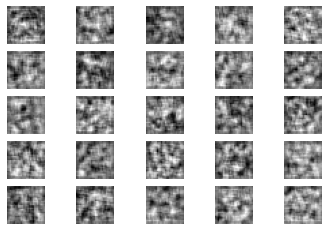

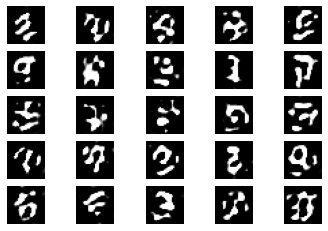

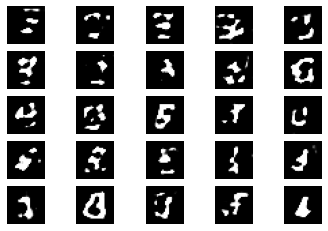

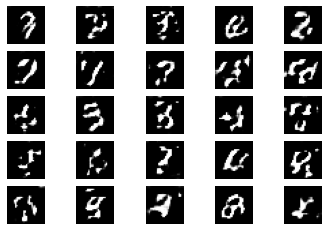

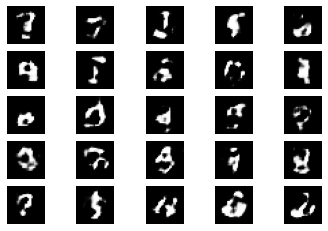

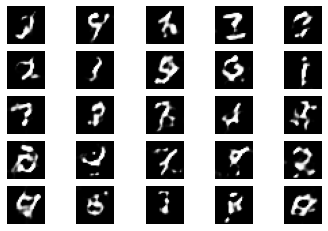

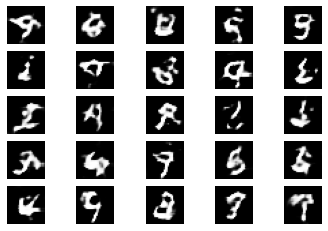

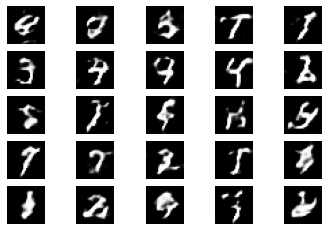

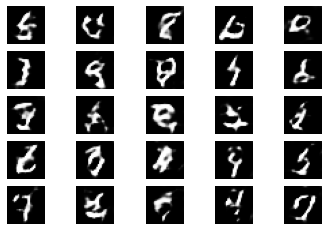

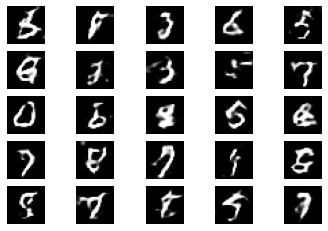

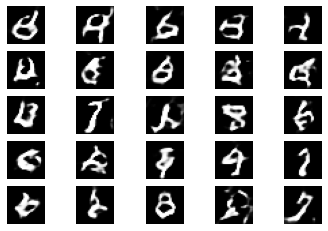

In [8]:
# 2000번 반복되고 (+1을 하는 것에 주의),
# 배치 크기는 32, 200번마다 결과가 저장됨

# 텐서를 GPU에 할당
# with tf.device('/GPU:0'):
gan_train(2001, 32, 200)